<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/ICAPS_SummerSchool_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integration of Task Planning and Motion Planning

In our previous tutorials ([1](https://colab.research.google.com/drive/1ZRp8WMJNjKbUFQuKF5Yjzuu-yTu8GTtW?usp=sharing) and [2](https://colab.research.google.com/drive/1-WZIhkmffYAvbIyFq5v2so38Fm_Oimnf?usp=sharing)), we introduced two concepts: task planning (TP) and motion planning (MP). We presented these ideas as a solution to problems like the one depicted in the image above. In task planning, we define the problem using a high-level representation that we can solve using planning methods like best-first search. In motion planning we instruct the agent how to achieve specific configurations in the real world. Let's remind ourselves with an example

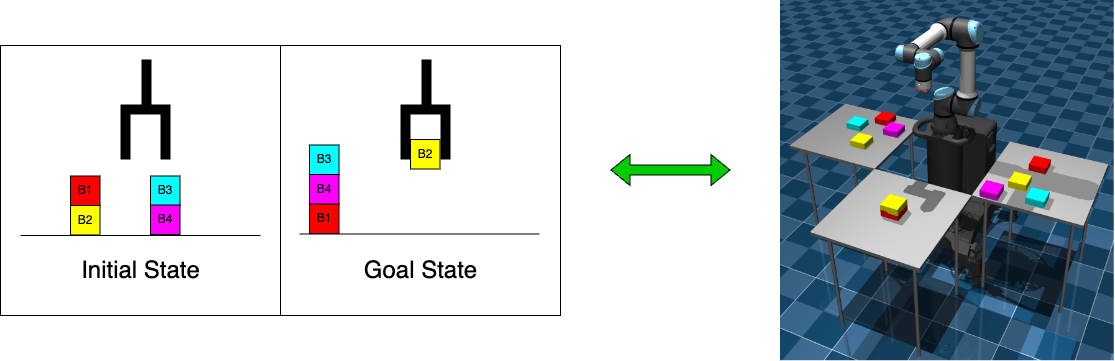

### Setup

In [ ]:
!pip install "aidm[pddl] @ git+https://github.com/CLAIR-LAB-TECHNION/aidm"
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

  Cloning https://github.com/CLAIR-LAB-TECHNION/aidm to /tmp/pip-install-3b97bl3t/aidm_2fe4ac981bc04a8c93505df66efbbf58
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/aidm /tmp/pip-install-3b97bl3t/aidm_2fe4ac981bc04a8c93505df66efbbf58
  Resolved https://github.com/CLAIR-LAB-TECHNION/aidm to commit cd2089da81615265ac940a94a45d3fa473793989
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/CLAIR-LAB-TECHNION/pddlgymnasium to /tmp/pip-install-3b97bl3t/pddlgymnasium_471300d7c5a740bb87c579d0432b087b
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/pddlgymnasium /tmp/pip-install-3b97bl3t/pddlgymnasium_471300d7c5a740bb87c579d0432b087b
  Resolved https://github.com/CLAIR-LAB-TECHNION/pddlgymnasium to commit ee1beaec167e064385696a1207c5b7ef31bdc906
  P

In [ ]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


## Recap

**NOTE: this is after ICKEPS so a recap is required**


### Task Planning


In tutorial 1, we presented a variation on the popular Blocks World  domain we call N-Table Blocks World where a robotic arm must rearrange colorful blocks on multiple tabletops. We defined this domain in PDDL:

In [ ]:
DOMAIN = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t -table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c -color)
 )

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)))

  (:action put-down
	     :parameters (?b - block ?t - table)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)))

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)))

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))))

"""

Given a specific problem, we showed how we can use the AI Decision-Makers library, `aidm`, to solve this problem with minimal effort.

In [ ]:
PROBLEM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T3)
(clear B2)
(bcolor B2 Y)

(ontable B3 T3)
(clear B3)
(bcolor B3 C)

(ontable B4 T3)
(clear B4)
(bcolor B4 P)

(ontable B5 T1)
(clear B5)
(bcolor B5 R)

(ontable B6 T1)
(clear B6)
(bcolor B6 Y)

(ontable B7 T1)
(clear B7)
(bcolor B7 C)

(ontable B8 T1)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(bcolor B9 R)

(on B10 B9)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B1 T2)
(ontable B5 T2)
))
)
"""

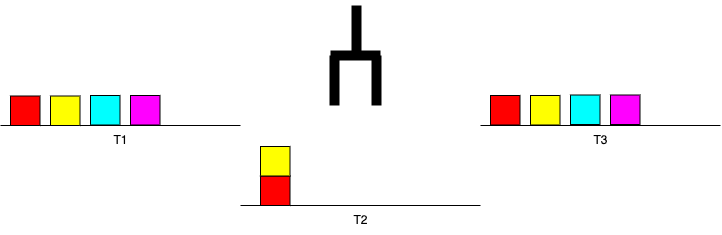

In [ ]:
from aidm.environments.pddl.pddl_problem import PDDLProblem
from aidm.search.best_first_search import breadth_first_search
from aidm.core.utils import print_results

# define PDDL problem
problem = PDDLProblem(domain_file=DOMAIN, problem_file=PROBLEM)

# solve using BFS
[best_node, best_plan, resources] = breadth_first_search(problem=problem,
                                                          iter_limit=1000,
                                                          logging=False)
print_results(info='breadth_first_search', node=best_node, plan=best_plan, resources=resources)

breadth_first_search
plan:
{'key': pick-up(b2:block,t3:table), 'content': pick-up(b2:block,t3:table)}
{'key': put-down(b2:block,t2:table), 'content': put-down(b2:block,t2:table)}
resources:iteration count:23 elapsed time (sec):0.47


 We also beifly presented the [MuJoCo simulator](https://mujoco.org/) and implemented a physically accurate N-Table Blocks World problem in it. In this simulation, we can control the robot arm and render for visualization.

In [ ]:
import mediapy as media
from numpy import pi
from n_table_blocks_world.n_table_blocks_world import NTableBlocksWorld

# initialize environment
env = NTableBlocksWorld(render_mode="rgb_array")
state = env.reset()

# set global framerate for the notebook
framerate = 60

# move to all joints at -45 degrees, for 100 steps:
frames = []  # container of rendered frames for video
action = [-pi/4]*6
for i in range(100):
    state = env.step(action)
    frames.append(env.render())

# show video:
media.show_video(frames, fps=framerate)

### Motion Planning

In tutorial 2, we presented motion planning which deals with continuous motion in the real world rather than high-level actions (as opposed to task planning). Using inverse kinematics we are able solve for a configuration of interest and to move to it to perform direct motions.

In [ ]:
from motion_planning.motion_planner import NTableBlocksWorldMotionPlanner
import numpy as np

framerate = 8

def move_to(env, target_config, tolerance=0.05, end_vel=0.1, max_steps=None,
            render_freq=8):
    '''
    move robot joints to target config, until it is close within tolerance,
    or max_steps exceeded.
    @param target_joint_pos: position to move to
    @param tolerance: distance withing configuration space to target to consider
     as reached
    @param max_steps: maximum steps to take before stopping, no limit if None
    @param render_freq: how often to render and append a frame
    @return: success, frames
    '''
    joint_positions = env.robot_joint_pos
    joint_velocities = env.robot_joint_velocities

    frames = []

    i = 0
    while np.linalg.norm(joint_positions - target_config) > tolerance \
    or np.linalg.norm(joint_velocities) > end_vel:
        if max_steps is not None and i > max_steps:
            return False, frames

        state = env.step(target_config)
        joint_positions = state['robot_joint_pos']
        joint_velocities = state['robot_joint_velocities']

        if i % render_freq == 0:
            frames.append(env.render())

        i += 1

    return True, frames

above_right_yellow_block = [-0.6, -0.6, 1.7, 0.7, pi/2, 0]

target_position = state['object_positions']['block 2 yellow']
target_position[2] += 0.1

motion_planner = NTableBlocksWorldMotionPlanner()
facing_down_R = [[0, 0, -1],
                 [0, 1, 0],
                 [1, 0, 0]]
above_yellow_block_config = motion_planner.ik_solve(goal_pos=target_position,
                                                    goal_R=facing_down_R,)

env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)
media.show_video(frames, fps=framerate)

Finally, we saw some more advanced methods for performing obstacle-aware sampling-based motion planning methods.

![motion planning](http://motion.cs.illinois.edu/RoboticSystems/figures/planning/prm.svg)

## Task **_Then_** Motion Planning

So we know how to task plan and we know how to motion plan. We must be done, right? Given an environment, we define the task we want to solve using PDDL, find the best plan, and enact that plan using SOTA motion planning methods to perform the actions defined in the PDDL in the continuous environment; easy peasy! Well. not exaclly...

### The Motion Planner Does Not Understand the Task Plan

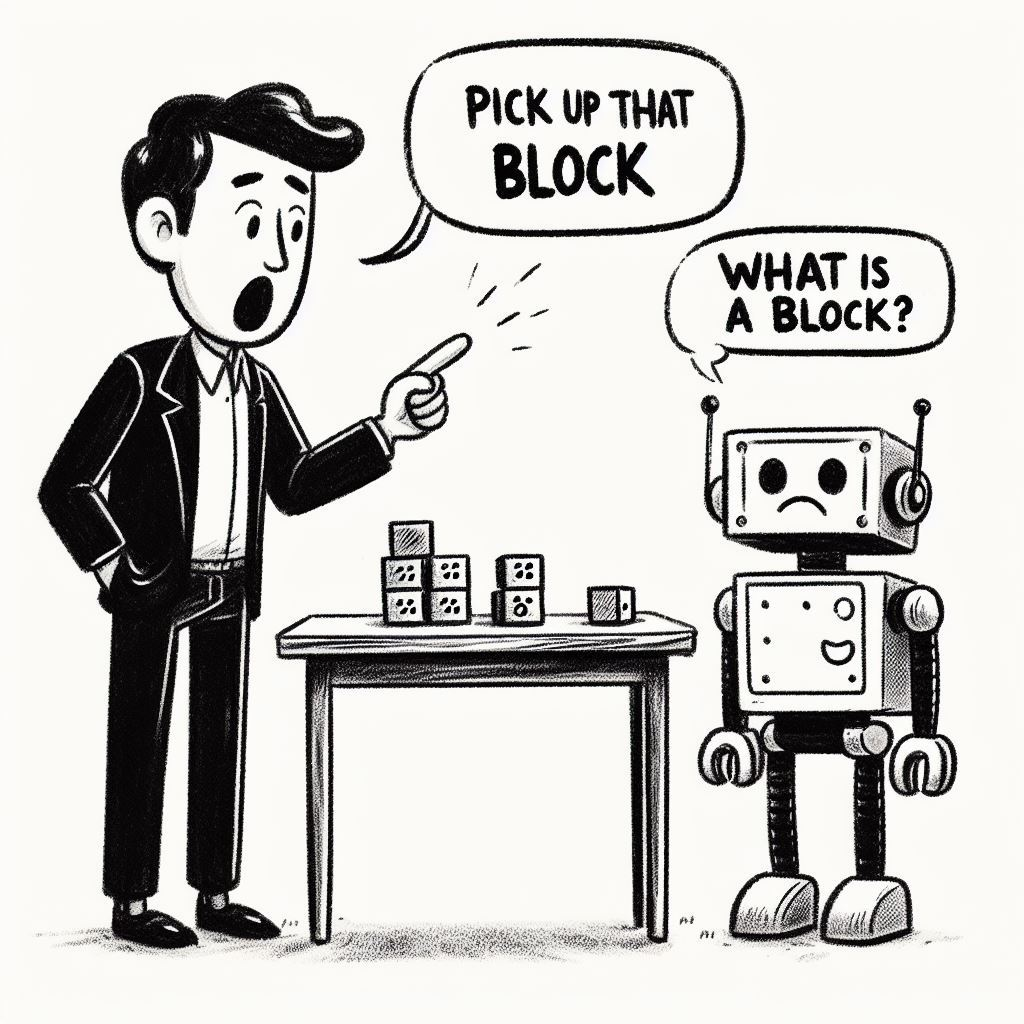

Our high-level PDDL representation of the world is simply an abstraction of our own design. The motion planner has no understanding of the concepts we defined. As such, we have a compatibility issue between the inputs and outputs of task planning and motion planning:

 **todo** - the motion planner has to kinds of outputs :
motion continous of a desired a configurfation or in the case of long-term
motion planning- a sequence of waypoins, which are configureations the robot needs to achieve

Torque control vs. position controller

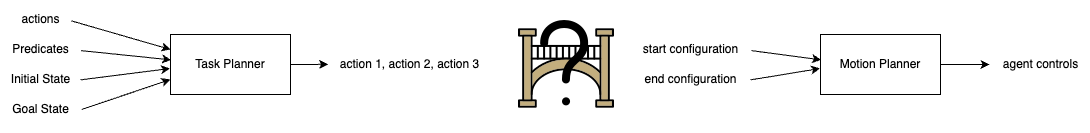

How can we bridge between the high-level plan given from the task planner and the initial and desired configurations in the pysical world required by the motion planner? Let us explore the naïve approach that is to write a direct mapping between the two realms.

### The Groudning Classifier

Let's begin with `start configuration`. How can this be obtained? We first need to verify that the initial high-level state in the PDDL problem file is the true state in the current world configuration, e.g., all blocks that are supposed to begin on `table1` are indeed somewhere on top of `table1` in the real world. It is also crucial to verify that we have actually reached the goal after a high-level plan is executed. For this, we need a mapping between world configurations and abstract PDDL states.

In TAMP, we call this the **grounding classifier**. We will now implement this function in steps to give you an idea of the effort required to implement such a function and the domain knowledge that is required.

Let's take a look at how objects are identified in MuJoCO:

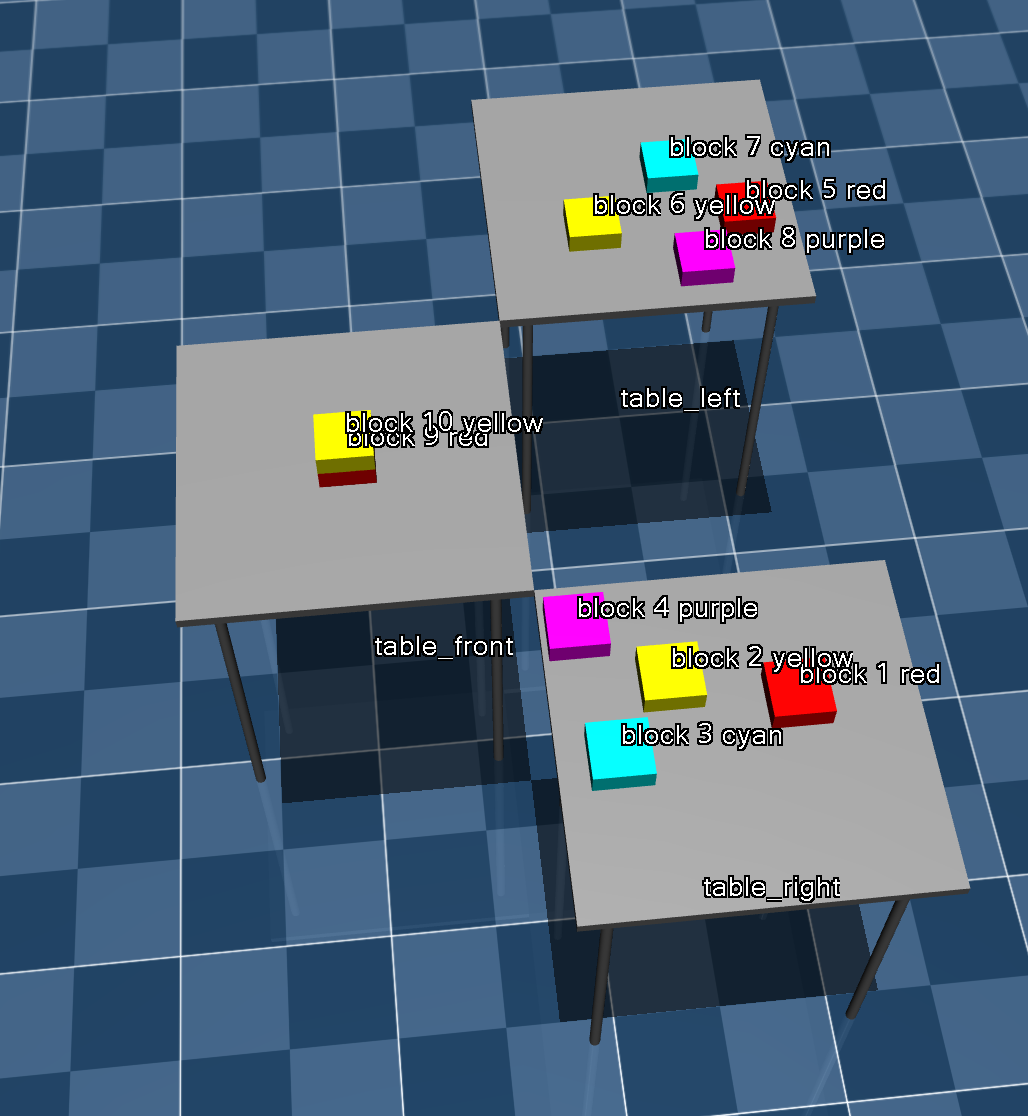

As we can see, blocks are numbered 1-10 with their color. Table names simply mention the position of the table relative to our default point-of-view (as in video demonstrations). Only _we_ know the correct way to match between the blocks and tables names in the PDDL and their names in the simulator. Let's create a table matching these names:

In [ ]:
# NOTE: PDDL is case-insensitive, and therefore most parsers default to lowercase object names.
OBJECT_PDDL_ID_TO_MUJOCO_NAME = {
    # tables
    't1': 'table_left_top',  # these are specifically the names for the table tops, not the entire table
    't2': 'table_front_top',
    't3': 'table_right_top',

    # blocks
    'b1': 'block 1 red',
    'b2': 'block 2 yellow',
    'b3': 'block 3 cyan',
    'b4': 'block 4 purple',
    'b5': 'block 5 red',
    'b6': 'block 6 yellow',
    'b7': 'block 7 cyan',
    'b8': 'block 8 purple',
    'b9': 'block 9 red',
    'b10': 'block 10 yellow'
}

# Convenience tables
TABLE_PDDL_IDS = [
    pddl_id
    for pddl_id in OBJECT_PDDL_ID_TO_MUJOCO_NAME.keys()
    if pddl_id.startswith('t')
]
BLOCK_PDDL_IDS = [
    pddl_id
    for pddl_id in OBJECT_PDDL_ID_TO_MUJOCO_NAME.keys()
    if pddl_id.startswith('b')
]

The grounding function is a function that tells us what predicates hold true. To implement this mapping, we need to use our understanding of the physical world and the semantics of the predicates themselves. We will, therefore, have to access the simulation directly and impose our understanding onto it. We start by extracting the underlying simulation from the environment and creating a mapping between PDDL ids and actionable objects bound to the simulation that we call entities.

**NOTE:** We are able to do this **because we aere in simulation**. In the real world we would have to work much harder to retreive and/or estimate the required information.

In [ ]:
mujoco_sim = env._env.sim

def pddl_id_to_mujoco_name(pddl_object_id):
  return OBJECT_PDDL_ID_TO_MUJOCO_NAME[pddl_object_id.lower()]

def pddl_id_to_table_entity(table_id):
  table_name = pddl_id_to_mujoco_name(table_id)
  return mujoco_sim.get_entity(table_name, 'geom')

def pddl_id_to_block_entity(block_id):
  block_name = pddl_id_to_mujoco_name(block_id)
  body_entity = mujoco_sim.get_entity(block_name)
  return body_entity.__class__(body_entity.mjcf_element.find_all('geom')[0], mujoco_sim.physics)

# State Estimation

**So far we connected the objects in the PDDL to the one in the real world (which is actually the simulation ** now we want to figure out which predicated hold true

As a first step we will implement all the predicates in the PDDL domain they reflect their respective semantic truth in the physical simulation. Let's start with implementing `on` and `ontable`. The simulator has no understanding of the notion "on" and thus we cannot just ask it directly. Luckily, MuJoCo provides the users with entity contact information. To determine whether one object is on top of another, we must check that the entity of the first object has an upward **normal force** toward entity of the first object.

## On table?

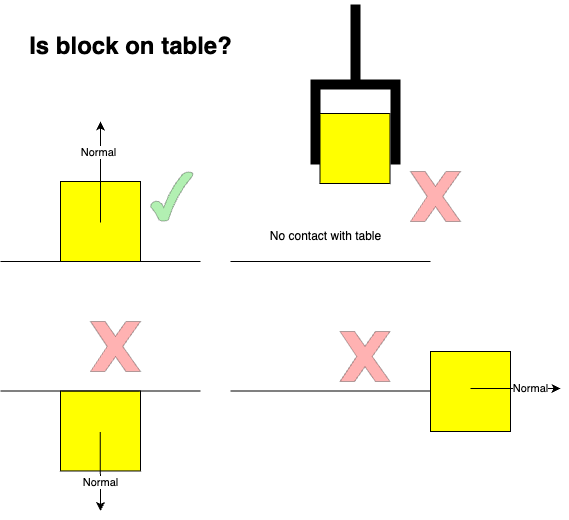

We have implemented for you the `physics_utils` module that can give us the normal force one object enacts upon another. Let's see which tables are applying force on B1:

In [ ]:
from n_table_blocks_world.physics_utils import get_normal_force

state = env.reset()
B1 = pddl_id_to_block_entity('B1')

for table_id in TABLE_PDDL_IDS:
  table = pddl_id_to_table_entity(table_id)
  print(f'{table_id} is applying force on B1 in direction {get_normal_force(table, B1, state)}')
print('conclusion: B1 is on table T3')

t1 is applying force on B1 in direction [0 0 0]
t2 is applying force on B1 in direction [0 0 0]
t3 is applying force on B1 in direction [ 0.00000000e+00 -1.59750646e-18  1.00000000e+00]
conclusion: B1 is on table T3


T3 is the only table in contact with B1. The direction of the force is up (toward the positive direction of the Z axis). We conclude that B1 is on table T3. We put this idea into a function to help us impolement our predicates.

In [ ]:
def entity_is_on_entity(entity1, entity2, state):
  """entity1 is considered "on" entity2 if the normal force from entity2 to entity1 is directly up"""
  normal = get_normal_force(entity2, entity1, state)
  normal_dist_from_up_dir = np.linalg.norm(normal - np.array([0, 0, 1]))
  return np.isclose(normal_dist_from_up_dir, 0)

FInally, we are able to implement the `on` and `ontable` predicates by asking if a block object's corresponding entity is on top of the entity of another block or table.

**NOTE:** In the NTBW domain, it is not possible for a block to be on something and also be currently held by the agent. In the physical world, this is definitely possible because **COMPLETE add image**. To overcome this, we will also have to implement the `holding` predicate so that we can ignore items being held.

Talk about **grasped object**

In [ ]:
def holding(block_id, state):
  block_name = pddl_id_to_mujoco_name(block_id)
  return state['grasped_object'] == block_name

def on(block1_id, block2_id, state):
  if holding(block1_id, state):
    return False

  block1 = pddl_id_to_block_entity(block1_id)
  block2 = pddl_id_to_block_entity(block2_id)

  return entity_is_on_entity(block1, block2, state)

def ontable(block_id, table_id, state):
  if holding(block_id, state):
    return False

  block = pddl_id_to_block_entity(block_id)
  table = pddl_id_to_table_entity(table_id)

  return entity_is_on_entity(block, table, state)

Let's see what we get when we check predicates on all argument combinations.

In [ ]:
for block in BLOCK_PDDL_IDS:
  if holding(block, state):
    print(f'agent is holding block {block}')
  for table in TABLE_PDDL_IDS:
    if ontable(block, table, state):
      print(f'block {block} is on table {table}')
  for block2 in BLOCK_PDDL_IDS:
    if on(block, block2, state):
      print(f'block {block} is on block {block2}')

block b1 is on table t3
block b2 is on table t3
block b3 is on table t3
block b4 is on table t3
block b5 is on table t1
block b6 is on table t1
block b7 is on table t1
block b8 is on table t1
block b9 is on table t2
block b10 is on block b9


The above output resonates with the truth as we preceive it We can verify this by going back to the labeled scene rendering above.

Let's continue this role and implement the other predicates that handle blocks and tables.

In [ ]:
def clear(block_id, state):
  return not holding(block_id, state) and not any(
      on(other_block_id, block_id, state)
      for other_block_id in BLOCK_PDDL_IDS
  )

def handempty(state):
  return not any(
      holding(block_id, state)
      for block_id in BLOCK_PDDL_IDS
  )

In [ ]:
for block in BLOCK_PDDL_IDS:
  if clear(block, state):
    print(f'block {block} is clear')
if handempty(state):
  print(f'Not holding any blocks')

block b1 is clear
block b2 is clear
block b3 is clear
block b4 is clear
block b5 is clear
block b6 is clear
block b7 is clear
block b8 is clear
block b10 is clear
Not holding any blocks


Again, the output is aligned with our understanding of the scene.

Remember that color is also an object type in the N-Table Blocks World domain. This is not really an object in the real world, but rather a property of block objects. Therefore we cannot map it directly to an entity in the simulator by name. However, we know all the possible colors and their representation in MuJoCo (RGBA). To test if a block is of a certain color, we simply query its color attribute and compare to the expected color value.

In [ ]:
COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO = {
    'r': np.array([1, 0, 0, 1]),
    'y': np.array([1, 1, 0, 1]),
    'c': np.array([0, 1, 1, 1]),
    'p': np.array([1, 0, 1, 1])
}

def bcolor(block_id, color_id, state):
  # NOTE: we do not use the state here because d
  block = pddl_id_to_block_entity(block_id)
  return np.all(block.rgba == COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO[color_id.lower()])

In [ ]:
for block in BLOCK_PDDL_IDS:
  for color in COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO.keys():
    if bcolor(block, color, state):
      print(f"block {block}'s color is {color}")

block b1's color is r
block b2's color is y
block b3's color is c
block b4's color is p
block b5's color is r
block b6's color is y
block b7's color is c
block b8's color is p
block b9's color is r
block b10's color is y


With that, we are ready to construct our grounding classifier. This is simply an aggregation of all predicates applied on all possible argument combinations, forming the literals that define the current state. Let's remind ourselves what the underlying PDDL state is made of.

In [ ]:
problem.env.get_state().literals

frozenset({bcolor(b10:block,y:color),
           bcolor(b1:block,r:color),
           bcolor(b2:block,y:color),
           bcolor(b3:block,c:color),
           bcolor(b4:block,p:color),
           bcolor(b5:block,r:color),
           bcolor(b6:block,y:color),
           bcolor(b7:block,c:color),
           bcolor(b8:block,p:color),
           bcolor(b9:block,r:color),
           clear(b10:block),
           clear(b1:block),
           clear(b2:block),
           clear(b3:block),
           clear(b4:block),
           clear(b5:block),
           clear(b6:block),
           clear(b7:block),
           clear(b8:block),
           handempty(),
           on(b10:block,b9:block),
           ontable(b1:block,t3:table),
           ontable(b2:block,t3:table),
           ontable(b3:block,t3:table),
           ontable(b4:block,t3:table),
           ontable(b5:block,t1:table),
           ontable(b6:block,t1:table),
           ontable(b7:block,t1:table),
           ontable(b8:block,t1:table),
     

Let's take the brute force approach. Given a state, iterate all predicates and test all possible combinations of input arguments for each predicate. Any predicate and input combination that yield `True` are saved as a part of the state.

In [ ]:
from pddlgymnasium.structs import State as PDDLState


class NTableBlocksWorldGroundingClassifier:
  def __init__(self, pddl_problem):
    self.all_ground_literals = pddl_problem.env.observation_space.all_ground_literals(pddl_problem.env.get_state())
    self.objects = frozenset(pddl_problem.env._problem.objects)
    self.goal = pddl_problem.env._problem.goal

  def __call__(self, state):
    ground_literals = set()
    for lit in self.all_ground_literals:
      pred_fn = eval(lit.predicate.name)
      vars = list(map(lambda v: v.name, lit.variables))
      if pred_fn(*vars, state):
        ground_literals.add(lit)

    return PDDLState(
        frozenset(ground_literals),
        self.objects,
        self.goal
    )

gc = NTableBlocksWorldGroundingClassifier(problem)

Let's classify the current state and compare it to the initial PDDL state:

In [ ]:
problem.env.get_state() == gc(state)

True

Finally we have a function that can verify that we are in the right state in the beginning. We can now safely assume that the `start configuration` is current configuration of the robot.

In [ ]:
#TODO display several images of different states in MuJoCo and show the groudning classifier output

### Grounding Sampler: The Inverse Grounding Classifier

The task planner has given us a high-level action plan. We have already verified that we are in the correct initial state of the high-level PDDL abstraction of the world. Now all we have to do is navigate the path induced by the planner, that is, iteratively perform motion plans that transition to the desired high-level PDDL states in the path. For this need to find the next confituration we need to achieve, i.e., we need to find `end_configuration`. We want a mapping that, given a high-level PDDL state, outputs the configuration we need to acheive with the motion_planner. Technically speaking, we want to sample a real-world state for which the grounding classifier outputs the desired high-level PDDL state. We call such a function the **grounding sampler**, that sampels from the inverse mapping of the groudning classifier.

In simple terms, the groudning sampler gives us a probable world state of the world that adheres to the semantic rules of the PDDL state. However, this can be very messy in practice. Simply sampling one possibility without constraints can lead to extremely different states than the current state. For example, since the PDDL model does not consider the blocks' positions on the tables, a state where B1 is on T3 and all other blocks remain where they are can be any state where all blocks remain on their current tables but whose positions on that table have changed. Therefore, unlike the groudning classifier, we will not implement a global gruonding sampler function, but rather interpolate in between the motions we perform.

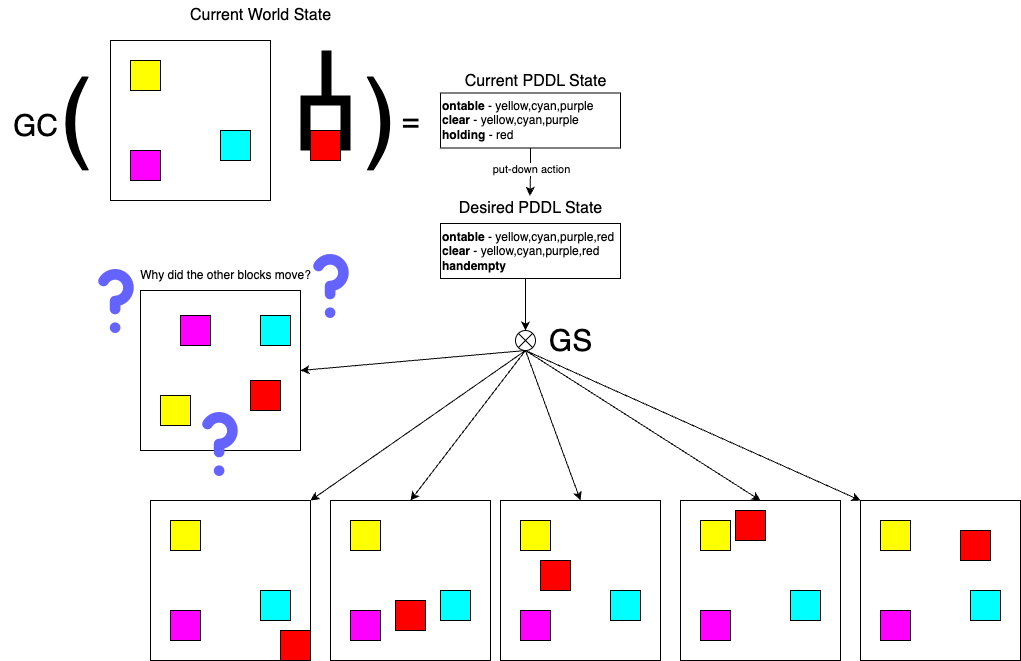

To do this, we must first realize that the motion planner only plans according to the robot and the objects attached to it. It does not consider the rest of the objects or their locations (other than for collision purposes). This means that the act of picking up an object is a multi-step act: first move above the block, then close the gripper. This leads us to the conclusion that we cannot simply sample configurations for the robot, but we must specifically implement the high-level actions defined in PDDL to perform the sequence of motion plans necessary to achieve the desired transition. We will call these **skills**. The functionality we need from the grounding sampler is implemented in-between the separate motions. Most of this is already implemented by the sampling-based methods we use. For example, in the previous tutorial we implemented a function to move above a specific block and got its position directly from the simulation. The only thing that remains is to sample a position on the relevant table on which we can put down blocks.

In [ ]:
def sample_on_table(table_id, z_offset=0.1):
  table_entity = pddl_id_to_table_entity(table_id)
  x_size, y_size, z_size = table_entity.size
  x, y, z = table_entity.center_of_mass
  x_range = [x - x_size / 2, x + x_size / 2]
  y_range = [y - y_size / 2, y + y_size / 2]
  sample_z = z + z_size + z_offset
  sample_x, sample_y = np.random.uniform(*np.array([x_range, y_range]).T)

  return np.array([sample_x, sample_y, sample_z])


**NOTE:** We only sample a spot on the table. we haven't even considered if that spot is free to place the block that we're holding. We will discuss these kinds of problems when we bring up geometrical constraints later in the notebook.

In [ ]:
from motion_planning.motion_executer import NTableBlocksWorldMotionExecuter

render_freq = 8
home_config = np.array([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0])

class SkillExecuter:
  def __init__(self, env):
    self.exec = NTableBlocksWorldMotionExecuter(env)

  def pick_up(self, block_id, table_id):
    block_name = pddl_id_to_mujoco_name(block_id)
    move_suc, move_frames = self.exec.move_above_block(block_name, render_freq=render_freq)
    grasp_suc, grasp_frames = self.exec.activate_grasp(render_freq=render_freq)
    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def put_down(self, block_id, table_id):
    table_pos = sample_on_table(table_id)
    move_suc, move_frames = self.exec.move_to_pose(table_pos)
    grasp_suc, grasp_frames = self.exec.deactivate_grasp(render_freq=render_freq)
    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def stack(self, block1_id, block2_id):
    # assume that the robot is already holding block1
    block2_name = pddl_id_to_mujoco_name(block2_id)
    move_suc, move_frames = self.exec.move_above_block(block2_name, render_freq=render_freq)
    grasp_suc, grasp_frames = self.exec.deactivate_grasp(render_freq=render_freq)
    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def unstack(self, block1_id, block2_id):
    return self.pick_up(block1_id, None)

  def go_home(self):
    return self.exec.move_to(home_config)

  def execute_plan(self, plan):
    pass

se = SkillExecuter(env)

Let's try this our. We will move block 1 from table 3 to table 2.

In [ ]:
# remove any randomness for demonstration purposes
import random
def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)

set_random_seed(126)

env.reset()

pick_success, pick_frames = se.pick_up('B1', 'T3')
put_suc, put_frames = se.put_down('B1', 'T2')
home_suc, home_frames = se.go_home()

media.show_video(np.concatenate([pick_frames, put_frames, home_frames]), fps=8)

planning...
planning...


Huzzah! Our skill executer is working beautifully! It isn't perfect, of course. Let's watch a failure case of the exact same execution.

In [ ]:
set_random_seed(42)

env.reset()

pick_success, pick_frames = se.pick_up('B1', 'T3')
put_suc, put_frames = se.put_down('B1', 'T2')
home_suc, home_frames = se.go_home()

media.show_video(np.concatenate([pick_frames, put_frames, home_frames]), fps=8)

planning...
planning...


Simply by sampling differently, the resulting motion can alter the PDDL state in unexpected wways. Did we achieve what we wanted, sure. But remember that this is only one short-horizon task that is most likely executed as part of a longer-horizon plan that may or may not want the cyan or purple blocks where they are (on table 3). What's more is now we have reached an invalid state where the cyan and purple blocksare neither on a table nor on another block so there is no valid action for picking them up if necessary. Let's see what the grounding classifier can do to alleviate this.

### Two-Way Grounding: Putting It All Together

Let's put everything together. Below we iterate the transition path of the plan we got earlier

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def execute_plan(env, best_node, gc, se)
  env.reset()
  suc, frames = True, []

  for state, action, next_state in best_node.get_transition_path():
    # no action for initial state transition
    if action is not None:
      # execute action
      action = action['content']

      # ===========================
      # GROUNDING SAMPLER USED HERE
      # ===========================
      skill = getattr(se, action.predicate.name.replace('-', '_'))
      args = vars = list(map(lambda v: v.name, action.variables))
      skill_suc, skill_frames = skill(*args)

      suc &= skill_suc
      frames.append(skill_frames)

    # check that we have reached the desired state after the transition
    # the first time this will be the initial state
    desired_cur_state = next_state['content']
    world_state = env.get_state()

    # ==============================
    # GROUNDING CLASSIFIER USED HERE
    # ==============================
    cur_state_est = gc(world_state)
    if not cur_state_est == desired_cur_state:
      raise ValueError(f'Acheived wrong state.\n\nexpected:\n{desired_cur_state}\n\nactual:\n{cur_state_ext}')


  home_suc, home_frames = se.go_home()
  suc &= home_suc
  frames.append(home_frames)

  return suc, frames

suc, frames = execute_plan(env, best_node, gc, se)

print('all motions success:', suc)
media.show_video(np.concatenate(frames), fps=8)

SyntaxError: expected ':' (<ipython-input-27-71d6fa2ad800>, line 5)

In [ ]:
HARDER_PROBLEM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T3)
(clear B2)
(bcolor B2 Y)

(ontable B3 T3)
(clear B3)
(bcolor B3 C)

(ontable B4 T3)
(clear B4)
(bcolor B4 P)

(ontable B5 T1)
(clear B5)
(bcolor B5 R)

(ontable B6 T1)
(clear B6)
(bcolor B6 Y)

(ontable B7 T1)
(clear B7)
(bcolor B7 C)

(ontable B8 T1)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(bcolor B9 R)

(on B10 B9)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B1 T2)
(on B4 B1)
(on B9 B4)
))
)
"""

harder_problem = PDDLProblem(DOMAIN, HARDER_PROBLEM)

# =============
# TASK PLANNING
# =============

# solve using BFS
[best_node, best_plan, resources] = breadth_first_search(problem=harder_problem,
                                                          iter_limit=100000,
                                                          logging=False)
print_results(info='breadth_first_search', node=best_node, plan=best_plan, resources=resources)

# ===============
# MOTION PLANNING
# ===============

# run execute plan in environment
suc, frames = execute_plan(env, best_node, gc, se)

print('all motions success:', suc)
media.show_video(np.concatenate(frames), fps=8)

- How can we be sure that the motion plan worked?
- what if we end up in an unexpected state?
- introduce naïve replanning

## Task **_AND_** Motion Planning

- hitherto expected the motion plan to simply work (deterministic + perfect planning).
  - task _then_ motion planning means we trust the motion planner to get us ther
- are we done? not yet.
  - so far we've addressed the limitations of the motion planner in understanding the task planner.
  - to complete integration, we must make the task planner understand the motion planner

### The Task Planner Does Not Understand Physical Motion

- The task planner does not take into consideration anything outside of the PDDL abstraction.
- we will show two interesting cases where this can interfere in completing the task.

### Constrained by Geometry

- e.g., what if there is not enough room on the table to add another block?
- our PDDL representation might be too abstract. What is the approriate abstraction level?
  - e.g., define a block limit per table.

### The Cost of Moving

- example: need to move a yellow block to some table. gripper is close to 1 that is under a red block and there is a free one in another table. should we unstack or move to the next one?
  - again... is the abstraction not sufficient?
    - e.g. introduce robot location and action cost

## Discussion



- Are we done now? probably never...

### The harsh reality of semantics

- semantics are not human interpretable
  - our implementation required lots of human intervention
    - we had to write quite a bit of domain-specific code
- semantics are subjective
  - there is no one true groudning between abstract world abstraction and the real world.
    - e.g., is a block on the table if it is touching the table with one edge and leaning on another block?
      - for stacking, probably not
      - for arrangement, possibly

### SOTA TAMP

- So far we implemented a naïve version of TAMP.
- what is SOTA?
  - learning with TAMP
  - TAMP with RL instead of motion control
  - pddlstream
  - ...
- demo [pddlstream](https://github.com/caelan/pddlstream)